# Applying CellPhenoX to Ulcerative Colitis Fibroblasts (single-cell transcriptomics)
## Goal: Identify subtle, fibroblast-specific phenotypic changes associated with differing levels of inflammation
This tutorial explores the utility of CellPhenoX within a specific cell type. Using the single-cell transcriptomics data from [Smillie et al.](https://doi.org/10.1016/j.cell.2019.06.029). We present the step-by-step workflow for running CellPhenoX to identify specific fibroblasts with predictable capability in distinguishing inflamed from non-inflamed colon.

## Importing Dependencies

In [1]:
#import pyCellPhenoX
import sys
sys.path.append('/Users/zhanglab_mac2/Documents/GitHub/pyCellPhenoX')
import pyCellPhenoX.CellPhenoX
import pyCellPhenoX.preprocessing
from pyCellPhenoX.neighborhoodAbundanceMatrix import neighborhoodAbundanceMatrix
import pyCellPhenoX.nonnegativeMatrixFactorization
import pyCellPhenoX.principalComponentAnalysis

import pandas as pd

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Step 1: Import data

In [2]:
# paths to expression data and meta data files
expression_file = "/Users/zhanglab_mac2/Documents/GitHub/pyCellPhenoX/vignettes/example_UC_data/fibroblast_exp.csv"
meta_file = "/Users/zhanglab_mac2/Documents/GitHub/pyCellPhenoX/vignettes/example_UC_data/fibroblast_met.csv"
output_path = "./output/"
# read in data
expression_mat = pd.read_csv(expression_file, index_col=0).T
meta = pd.read_csv(meta_file, index_col=0)

In [3]:
print(expression_mat.shape)
print(meta.shape)

(14822, 5494)
(14822, 10)


In [4]:
meta.head()

,sample,disease,cell_type,cluster,nGene,nUMI,percent_mito,fibroblast_clusters,UMAP1,UMAP2
cell,,,,,,,,,,
N7.LPA.AAACATACCATTTC,N7,Non-inflamed,LP,WNT2B+ Fos-lo 1,550.0,1118.0,0.029517,WNT2B,9.517501,2.068284
N7.LPA.AAACGCTGTATCGG,N7,Non-inflamed,LP,Myofibroblasts,636.0,1312.0,0.025915,Myofibroblasts,-0.044317,-4.302498
N7.LPA.AAAGACGAGACAGG,N7,Non-inflamed,LP,WNT2B+ Fos-hi,1030.0,2594.0,0.021982,WNT2B,9.716670,0.810530
N7.LPA.AAAGATCTAGTCTG,N7,Non-inflamed,LP,WNT2B+ Fos-hi,707.0,1769.0,0.019220,WNT2B,-4.460246,6.526924
N7.LPA.AAATACTGCTGGAT,N7,Non-inflamed,LP,WNT2B+ Fos-hi,786.0,1921.0,0.021365,WNT2B,-5.412079,6.846126


## Step 2: Preprocess data - generate latent dimensions and configure input for CellPhenoX (include covariates and identify target column)

First, we generate the NAM to summarize the cell co-abundance. CellPhenoX offers a wrapper around the Python [CNA](https://github.com/immunogenomics/cna) package functions to accomplish this, `neighborhoodAbundanceMatrix`. 

Parameters:
- `expression_mat` - the single-cell omics feature matrix (with cells as rows and features as columns)
- `meta` - corresponding meta data where columns are categories
- `sampleid` - the name of the column in meta that has the individual/subject identification

In [5]:
#nam = neighborhoodAbundanceMatrix(expression_mat=expression_mat, meta_data=meta, sampleid="sample")

In [6]:
nam = pd.read_csv("/Users/zhanglab_mac2/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Zhang_Lab/Research/shap/cell_neighborhood_abundance/NAM_cellXnbhd.csv", index_col=0)
nam.head()

,N7.LPA.AAACATACCATTTC,N7.LPA.AAACGCTGTATCGG,N7.LPA.AAAGACGAGACAGG,N7.LPA.AAAGATCTAGTCTG,N7.LPA.AAATACTGCTGGAT,N7.LPA.AAATGGGAAAGTAG,N7.LPA.AAATGTTGGTTACG,N7.LPA.AACACGTGGAGAGC,N7.LPA.AACCAGTGATCGTG,N7.LPA.AACCGATGGAGAGC,...,N110.LPB.TTCCCAGTCAACGCTA,N110.LPB.TTCTCAAAGTGCGTGA,N110.LPB.TTCTCAATCCGTTGTC,N110.LPB.TTCTTAGCAGCTATTG,N110.LPB.TTGAACGCAATGACCT,N110.LPB.TTGAACGGTCTGATTG,N110.LPB.TTGGAACAGAGCTTCT,N110.LPB.TTGGAACCAATCTACG,N110.LPB.TTGTAGGCAGAGTGTG,N110.LPB.TTTCCTCCATGCAATC
N7.LPA.AAACATACCATTTC,0.000073,0.000026,0.000053,0.000046,0.000037,0.000050,0.000053,0.000044,0.000061,0.000050,...,0.000023,0.000025,0.000032,0.000019,0.000016,0.000034,0.000019,0.000024,0.000029,0.000025
N7.LPA.AAACGCTGTATCGG,0.000026,0.000097,0.000034,0.000026,0.000024,0.000036,0.000037,0.000027,0.000030,0.000033,...,0.000016,0.000018,0.000023,0.000043,0.000049,0.000025,0.000050,0.000035,0.000040,0.000018
N7.LPA.AAAGACGAGACAGG,0.000053,0.000034,0.000078,0.000049,0.000037,0.000053,0.000047,0.000047,0.000055,0.000049,...,0.000023,0.000025,0.000032,0.000026,0.000023,0.000035,0.000026,0.000031,0.000035,0.000026
N7.LPA.AAAGATCTAGTCTG,0.000046,0.000026,0.000049,0.000064,0.000042,0.000042,0.000033,0.000048,0.000041,0.000039,...,0.000041,0.000043,0.000051,0.000023,0.000018,0.000053,0.000023,0.000033,0.000030,0.000042
N7.LPA.AAATACTGCTGGAT,0.000037,0.000024,0.000037,0.000042,0.000069,0.000037,0.000037,0.000043,0.000036,0.000039,...,0.000045,0.000046,0.000055,0.000023,0.000018,0.000054,0.000026,0.000034,0.000029,0.000046


CellPhenoX has two functions that will decompose the NAM, `nonnegativeMatrixFactorization` and `principalComponentAnalysis`.

_Note_: if using a different dimensionality reduction technique, ensure that the format of the latent embeddings are in the following format for the preprocessing step (cells as rows, latent embeddings as columns).

`nonnegativeMatrixFactorization` uses NMF to generate the ranks from the NAM. 

Parameters:
- `numberOfComponents` - the number of ranks (latent embeddings) to learn. Default = -1; if the number of components is not specified, then we select the number of components by performing NMF on a range of k values and selecting the one with the highest silhouette score.
    - `min_k` - minimum for the range
    - `max_k` - maximum for the range

In [7]:
# get the latent dimensions using NMF
latent_features = pyCellPhenoX.nonnegativeMatrixFactorization(nam, numberOfComponents=4, min_k=3, max_k=5)

inside the NMF function


Alternatively, we can perform PCA with `principalComponentAnalysis` and use the principal components as the latent embeddings.

Paramters:
- `var` - the desired proportion of variance explained. This will be used to select the number of principal components.

In [ ]:
proportion_var_explained = 0.9
latent_features = pyCellPhenoX.principalComponentAnalysis(nam, var=proportion_var_explained)

Now that we have the latent dimensions, the `preprocessing` function will add desired covariates to the model predictor dataframe, `X`, label encode any non-numerical columns to be used in the classification model, and optionally perform subsampling. 

Parameters:
- `sub_samp` - boolean flag, do you want to subsample your data
- `subset_percentage` - if `sub_samp` is True, specify the desired proportion of the dataset
- `bal_col` - name of columns to use to balance the subsampling
- `target` -  name of the column in the meta data for the target/outcome variable for the classification model
- `covariates` - list of column names for covariates that you want to include as features in the classification model 

In [8]:
X,y = pyCellPhenoX.preprocessing(latent_features, meta, sub_samp=False, bal_col=["subject_id", "cell_type", "disease"], subset_percentage=0.25 , target="disease", covariates=[], interaction_covs=[])
X.head()

,LD_1,LD_2,LD_3,LD_4
cell,,,,
N7.LPA.AAACATACCATTTC,0.009308,0.000000,0.001079,0.000979
N7.LPA.AAACGCTGTATCGG,0.003498,0.006898,0.000760,0.000000
N7.LPA.AAAGACGAGACAGG,0.009174,0.000690,0.001217,0.000000
N7.LPA.AAAGATCTAGTCTG,0.006249,0.000114,0.002191,0.000024
N7.LPA.AAATACTGCTGGAT,0.004989,0.000571,0.002303,0.000273


## Step 3: Run CellPhenoX - train the classification model and calculate the CellPhenoX Interpretable Score

We start by instantiating the CellPhenoX object with `CellPhenoX`, specifying the following attributes:
- `outer_num_splits` - the number of cross validation folds.
- `inner_num_splits` - the number of cross validation folds for the hyperparameter grid search.
- `CV_repeats` - the number of cross validation repeats to perform. This ensures that the SHAP values calculated are robust to the randomization of the folds; the final SHAP values for each cell for each feature will be the average across CV repeats.

The function for running this step is `model_training_shap_val`. You can pass the path to a specific output path for the produced plots.

entering CV loop

------------ CV Repeat number: 1

------ Fold Number: 1
--- Accuracy:  0.7589556769884639
--- Validation Accuracy:  0.8371269600404654  - Validation AUROC:  0.906510750194665  - Val AUPRC:  0.9319760696879232

------ Fold Number: 2
--- Accuracy:  0.7623962760574783
--- Validation Accuracy:  0.8730399595346484  - Validation AUROC:  0.9506476072147357  - Val AUPRC:  0.9688343084059845

------ Fold Number: 3
--- Accuracy:  0.7562753036437248
--- Validation Accuracy:  0.8148710166919575  - Validation AUROC:  0.8948686063679958  - Val AUPRC:  0.9241212208127081
best model precision-recall score = 0.9688


/Users/zhanglab_mac2/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Zhang_Lab/Research/shap/.conda/lib/python3.11/site-packages/shap/plots/_beeswarm.py:699: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


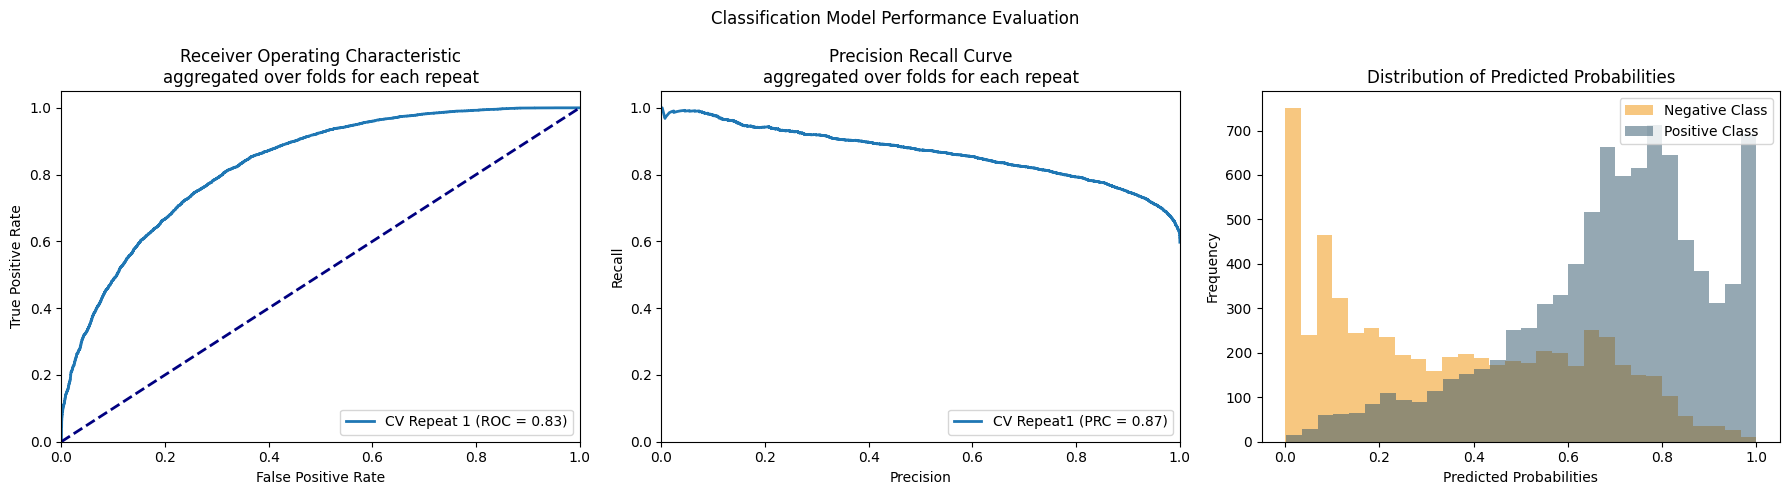

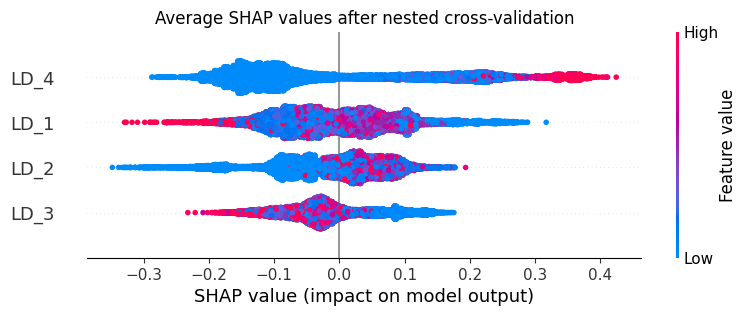

In [9]:
# create CellPhenoX object 
cellpx_obj = pyCellPhenoX.CellPhenoX(X, y, CV_repeats=1, outer_num_splits=3, inner_num_splits=2)
# and then train the classification model
cellpx_obj.model_training_shap_val(outpath = "/Users/zhanglab_mac2/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Zhang_Lab/Research/shap/xcell/xcell_tutorial/xcell_results/ulcerative_colitis")

The `.shap_df` attribute will hold the SHAP values for the individual features in the model (these columns will have the names of the features and "_shap"). The `interpretable_score` column holds the CellPhenoX Interpretable Score.

In [10]:
shap_df = cellpx_obj.shap_df
shap_df.head()

,LD_1_shap,LD_2_shap,LD_3_shap,LD_4_shap,interpretable_score
cell,,,,,
N7.LPA.AAACATACCATTTC,-0.041487,-0.277409,-0.122060,0.146939,-0.294018
N7.LPA.AAACGCTGTATCGG,-0.093365,0.033859,-0.033869,-0.198160,-0.291535
N7.LPA.AAAGACGAGACAGG,-0.057741,0.022331,-0.125413,-0.143444,-0.304266
N7.LPA.AAAGATCTAGTCTG,-0.004691,-0.132704,-0.049079,-0.120268,-0.306743
N7.LPA.AAATACTGCTGGAT,0.011309,-0.081440,-0.104100,0.068575,-0.105656


## Step 4: Visualization - generate manuscript plots

In [11]:
# VISUALIZATION
from pyCellPhenoX.plot_interpretablescore_umap import plot_interpretablescore_umap
from pyCellPhenoX.plot_interpretablescore_boxplot import plot_interpretablescore_boxplot

In [12]:
shap_df = shap_df.set_index(meta.index)
results_df = pd.concat([shap_df, meta], axis=1)
results_df.head()

,LD_1_shap,LD_2_shap,LD_3_shap,LD_4_shap,interpretable_score,sample,disease,cell_type,cluster,nGene,nUMI,percent_mito,fibroblast_clusters,UMAP1,UMAP2
cell,,,,,,,,,,,,,,,
N7.LPA.AAACATACCATTTC,-0.041487,-0.277409,-0.122060,0.146939,-0.294018,N7,Non-inflamed,LP,WNT2B+ Fos-lo 1,550.0,1118.0,0.029517,WNT2B,9.517501,2.068284
N7.LPA.AAACGCTGTATCGG,-0.093365,0.033859,-0.033869,-0.198160,-0.291535,N7,Non-inflamed,LP,Myofibroblasts,636.0,1312.0,0.025915,Myofibroblasts,-0.044317,-4.302498
N7.LPA.AAAGACGAGACAGG,-0.057741,0.022331,-0.125413,-0.143444,-0.304266,N7,Non-inflamed,LP,WNT2B+ Fos-hi,1030.0,2594.0,0.021982,WNT2B,9.716670,0.810530
N7.LPA.AAAGATCTAGTCTG,-0.004691,-0.132704,-0.049079,-0.120268,-0.306743,N7,Non-inflamed,LP,WNT2B+ Fos-hi,707.0,1769.0,0.019220,WNT2B,-4.460246,6.526924
N7.LPA.AAATACTGCTGGAT,0.011309,-0.081440,-0.104100,0.068575,-0.105656,N7,Non-inflamed,LP,WNT2B+ Fos-hi,786.0,1921.0,0.021365,WNT2B,-5.412079,6.846126


We present the step-by-step workflow for running CellPhenoX to identify specific fibroblasts with predictable capability in distinguishing inflamed from non-inflamed colon.

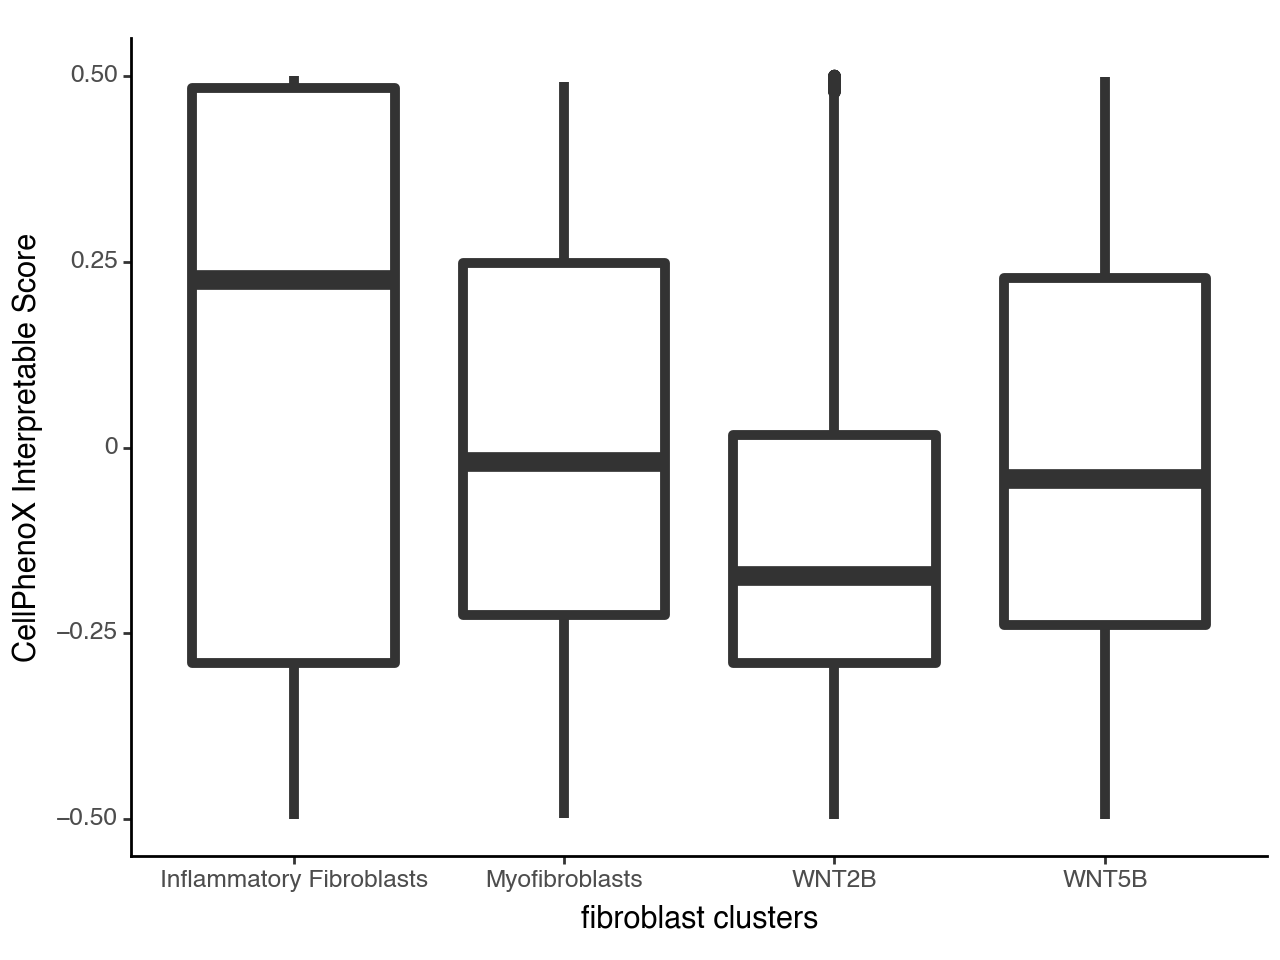

In [13]:
b = plot_interpretablescore_boxplot(data=results_df, x="fibroblast_clusters", y='interpretable_score')
print(b)

CellPhenoX Interpretable Score on the UMAP & cell type labeled accordingly. This further confirmed that the identified inflammatory fibroblasts consistently show the highest scores, with a clear gradient extending toward a subset of WNT2B+ fibroblasts.

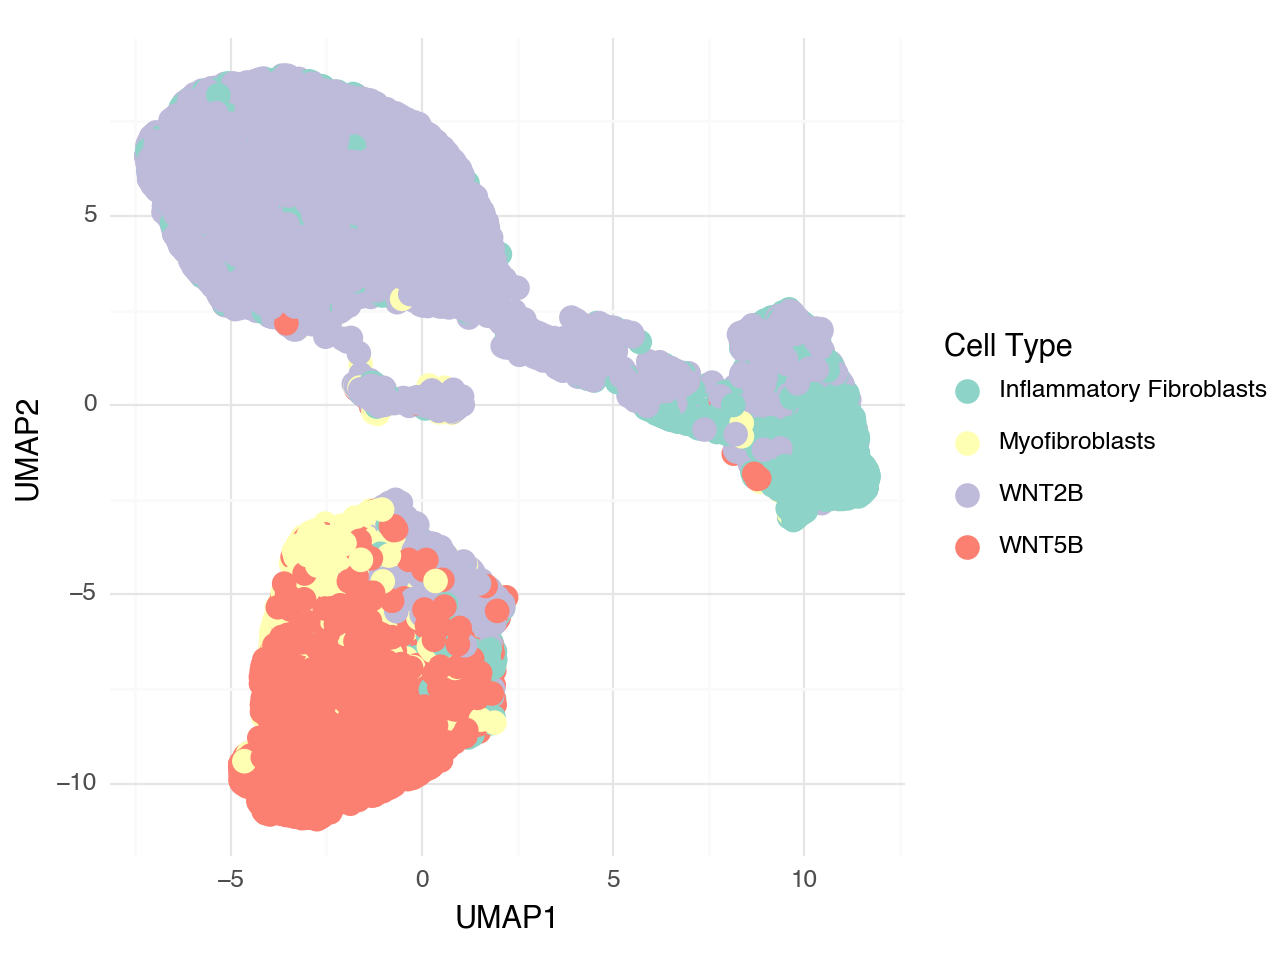

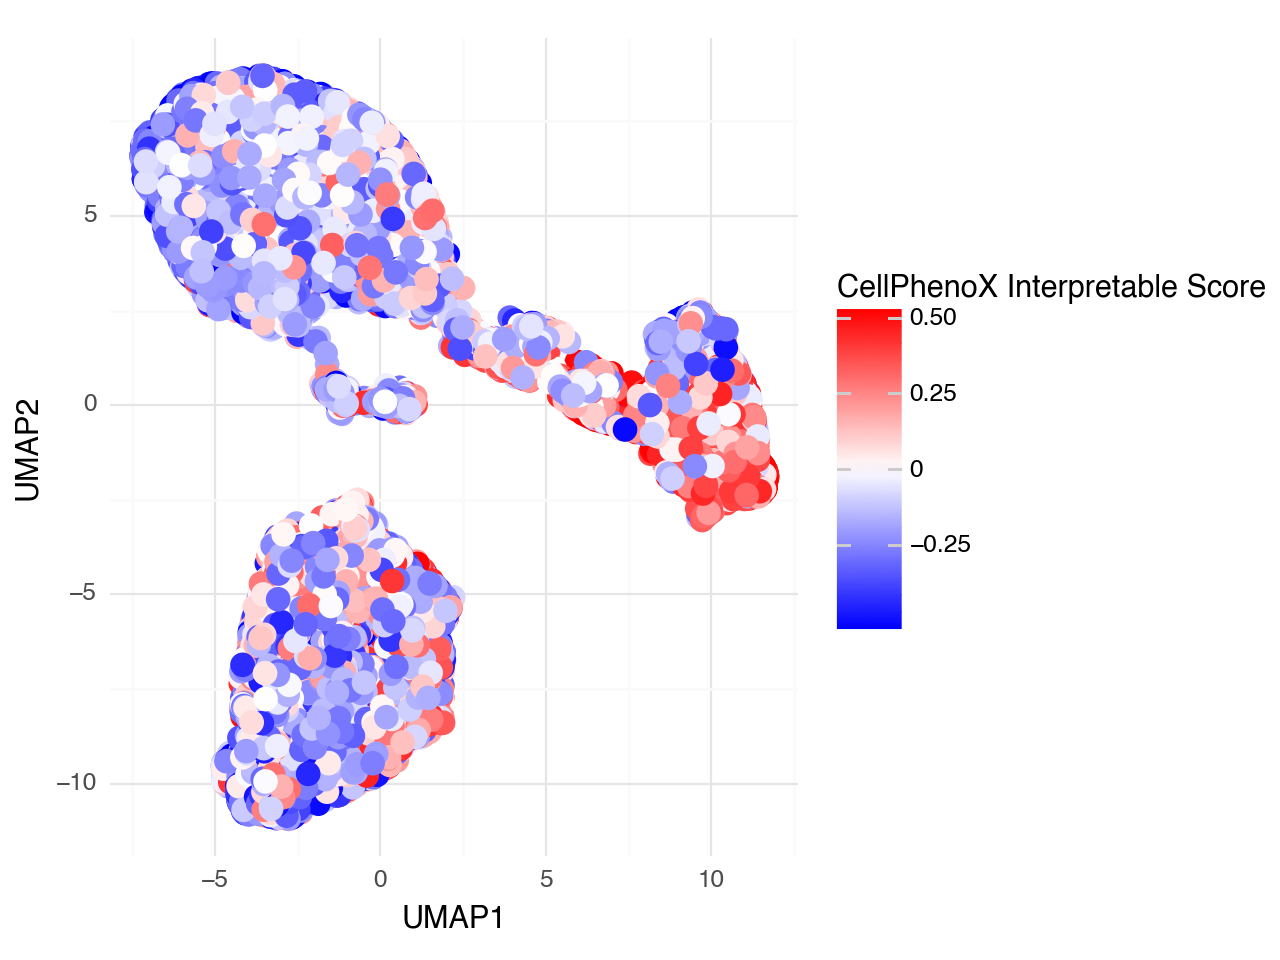

In [14]:
c, s = plot_interpretablescore_umap(data=results_df, x="UMAP1", y="UMAP2", cell_type="fibroblast_clusters", score="interpretable_score")
print(c)
print(s)